In [6]:
import torch
from torch import nn
from torchvision import transforms

import cv2

In [21]:
# del new_model, resnet18, resnet50, resnet101
torch.cuda.empty_cache()

## Preprocessing

In [ ]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

### Train

In [ ]:
preprocessing = transforms.Compose([
    transforms.RandomSizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize,
])

### Val

In [ ]:
preprocessing = transforms.Compose([
    transforms.Scale(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    normalize,
])

In [10]:
INPUT_WIDTH = 224

In [17]:
normalise = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]) 

In [30]:
def preprocess(np_image_bgr):
    '''
    Preprocessing for embedder network: Flips BGR to RGB, resize, convert to torch tensor, normalise with imagenet mean and variance, reshape. Note: input image yet to be loaded to GPU through tensor.cuda()

    Parameters
    ----------
    np_image_bgr : ndarray
        (H x W x C) in BGR

    Returns
    -------
    Torch Tensor

    '''
    np_image_rgb = np_image_bgr[...,::-1]
    np_image_rgb = cv2.resize(np_image_rgb, (INPUT_WIDTH, INPUT_WIDTH))
    input_image = transforms.ToTensor()(np_image_rgb)
    input_image = normalise(input_image) 
#     input_image = input_image.view(1,3,INPUT_WIDTH,INPUT_WIDTH)
    return input_image

In [60]:
from torch import nn
from pathlib import Path
import torchvision.models as models

class Resnet_Embedder(object):
    '''
    Resnet_Embedder loads a resnet pretrained on Imagenet1000, with classification layer removed, exposing the bottleneck layer, outputing a feature of size 1280. 
    '''
    def __init__(self, model_wts_path = None, depth=50, bs=8):
        if model_wts_path is None:
            pretrained=True
        else:
            pretrained=False
            assert Path(model_wts_path).is_file(),'Model path does not exists!'
            
        if depth == 18:
            full_model = models.resnet18(pretrained=pretrained)
        elif depth == 50:
            full_model = models.resnet50(pretrained=pretrained)
        elif depth == 101:
            full_model = models.resnet101(pretrained=pretrained)
        else:
            assert True,'Resnet with specified depth {} does not exist!'.format(depth)

        with torch.no_grad():
            self.model = nn.Sequential(*list(full_model.children())[:-1])
            del full_model
        self.model.cuda() #loads model to gpu
        self.model.eval() #inference mode, deactivates dropout layers 
        print('Resnet{} Embedder initialised!'.format(depth))
        self.bs = bs
        self.model.forward(torch.zeros(self.bs, 3, INPUT_WIDTH, INPUT_WIDTH).cuda()) #warmup

    def preprocess(self, np_image_bgr):
        '''
        Preprocessing for embedder network: Flips BGR to RGB, resize, convert to torch tensor, normalise with imagenet mean and variance, reshape. Note: input image yet to be loaded to GPU through tensor.cuda()

        Parameters
        ----------
        np_image_bgr : ndarray
            (H x W x C) in BGR

        Returns
        -------
        Torch Tensor

        '''
        np_image_rgb = np_image_bgr[...,::-1]
        np_image_rgb = cv2.resize(np_image_rgb, (INPUT_WIDTH, INPUT_WIDTH))
        input_image = transforms.ToTensor()(np_image_rgb)
        input_image = normalise(input_image) 
#         input_image = input_image.view(1,3,INPUT_WIDTH,INPUT_WIDTH)
        return input_image

    def forward(self, batch_tensor):
        feats = self.model.forward(batch_tensor.cuda())
        return feats.cpu().data.numpy()
    
    def predict(self, np_image_bgr):
        '''
        singly inference

        Params
        ------
        np_image_bgr : ndarray
            list of (H x W x C) in BGR
        
        Returns
        ------
        features (np.array)

        '''
        input_img = self.preprocess(np_image_bgr).cuda()
        feats = self.model.forward(input_img)
        return feats[0].cpu().data.numpy().flatten()

    def predict_batch(self, list_of_np_image_bgr):
        '''
        singly inference

        Params
        ------
        list_of_np_image_bgr : list of ndarray
            list of (N x H x W x C) in BGR
        
        Returns
        ------
        list of features (np.array with dim = 1280)

        '''
        
        for i in range(0, len(list_of_np_image_bgr), self.bs):
            in_batch = preprocess(list_of_np_image_bgr[i:i+self.bs])
            res = self.model.forward(in_batch)
        
        input_img = self.preprocess(np_image_bgr).cuda()
        feats = self.model.forward(input_img)
        return feats[0].cpu().data.numpy().flatten()
    
    

In [61]:
resmodel = Resnet_Embedder(depth=50)

Resnet50 Embedder initialised!


In [51]:
import cv2
from pathlib import Path
from torch.utils.data import Dataset, DataLoader

class IndoorDataset(Dataset):
    """Indoor Scene dataset."""

    def __init__(self, root_dir, preproc=None):
        """
        Args:
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        assert Path(root_dir).is_dir()
        self.impaths = []
        for ext in ['jpg','png','jpeg']:
            self.impaths.extend(Path(root_dir).glob('*.{}'.format(ext)))
        self.preproc = preproc

    def __len__(self):
        return len(self.impaths)

    def __getitem__(self, idx):
        impath = self.impaths[idx]
        X = cv2.imread(str(impath))
        if self.preproc:
            X = self.preproc(X)
        y = '_'.join(impath.stem.split('_')[:2])

        return X, y


In [67]:
indoorDataset = IndoorDataset('/media/dh/HDD1/roomid/dsta', preproc=resmodel.preprocess)
# indoorDataset = IndoorDataset('/media/dh/HDD1/roomid/dsta')

Evan_2


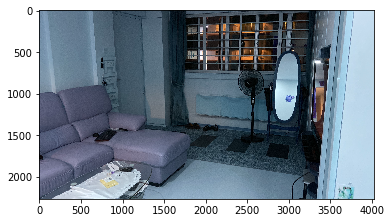

In [25]:
import matplotlib.pyplot as plt
X, y = indoorDataset[10]
imgplot = plt.imshow(X)
print(y)
plt.show()

In [43]:
# X, y = indoorDataset[10]
# print(y)
# print(X.shape)

Evan_2
torch.Size([3, 224, 224])


In [68]:
dataloader = DataLoader(indoorDataset, batch_size=4, shuffle=False, num_workers=4)

In [45]:
# next(iter(dataloader))[0].shape

torch.Size([4, 3, 224, 224])

In [48]:
# for i, Xy in enumerate(dataloader):
#     print(i)
#     print(Xy[1])
#     print(Xy[0].shape)

0
('JaneS_2', 'JaneS_2', 'JaneS_1', 'Evan_3')
torch.Size([4, 3, 224, 224])
1
('LeslieLim_2', 'JaneS_1', 'LeslieLim_1', 'Evan_1')
torch.Size([4, 3, 224, 224])
2
('Evan_1', 'JaneS_2', 'Evan_2', 'Evan_1')
torch.Size([4, 3, 224, 224])
3
('Evan_3', 'LeslieLim_2', 'JaneS_2', 'Evan_1')
torch.Size([4, 3, 224, 224])
4
('Evan_2', 'Evan_3', 'Evan_1', 'JaneS_1')
torch.Size([4, 3, 224, 224])
5
('JaneS_1', 'JaneS_2', 'Evan_3', 'Evan_2')
torch.Size([4, 3, 224, 224])
6
('Evan_1', 'LeslieLim_1')
torch.Size([2, 3, 224, 224])


In [69]:
embedding_pairs = []
for i, Xy in enumerate(dataloader):
    X, y = Xy
    embs = resmodel.forward(X)
    for i, label in enumerate(y):
        embedding_pairs.append((label, embs[i,].flatten()))

In [70]:
len(embedding_pairs)

69

In [101]:
embedding_pairs = sorted(embedding_pairs, key=lambda x : x[0])

In [138]:
labels_only = [pair[0] for pair in embedding_pairs]

In [128]:
import string
abc = string.ascii_uppercase
label2abc = {}
for i, label in enumerate(sorted(list(set(labels_only)))):
    label2abc[label] = abc[i]
label2abc

{'Ak_1': 'A',
 'Akash_1': 'B',
 'Akash_2': 'C',
 'AstridLew_1': 'D',
 'AstridLew_2': 'E',
 'AstridLew_3': 'F',
 'AstridLew_4': 'G',
 'Evan_1': 'H',
 'Evan_2': 'I',
 'Evan_3': 'J',
 'JaneS_1': 'K',
 'JaneS_2': 'L',
 'LeslieLim_1': 'M',
 'LeslieLim_2': 'N',
 'RenJie_1': 'O',
 'RenJie_2': 'P',
 'RenJie_3': 'Q',
 'RenJie_4': 'R',
 'RenJie_5': 'S',
 'RenJie_6': 'T'}

In [129]:
new_labels = [label2abc[l] for l in labels_only]
new_labels

['A',
 'A',
 'B',
 'B',
 'B',
 'B',
 'C',
 'C',
 'D',
 'D',
 'E',
 'E',
 'F',
 'F',
 'G',
 'G',
 'G',
 'G',
 'G',
 'G',
 'H',
 'H',
 'H',
 'H',
 'H',
 'H',
 'I',
 'I',
 'I',
 'J',
 'J',
 'J',
 'J',
 'K',
 'K',
 'K',
 'K',
 'L',
 'L',
 'L',
 'L',
 'L',
 'M',
 'M',
 'N',
 'N',
 'O',
 'O',
 'O',
 'O',
 'P',
 'P',
 'P',
 'P',
 'Q',
 'Q',
 'R',
 'R',
 'R',
 'R',
 'R',
 'S',
 'S',
 'S',
 'S',
 'T',
 'T',
 'T',
 'T']

In [104]:
embeddings_only = [pair[1] for pair in embedding_pairs]

In [71]:
from scipy.spatial import distance_matrix

In [105]:
dist_mat = distance_matrix(embeddings_only, embeddings_only)

In [106]:
dist_mat.shape

(69, 69)

In [97]:
import seaborn

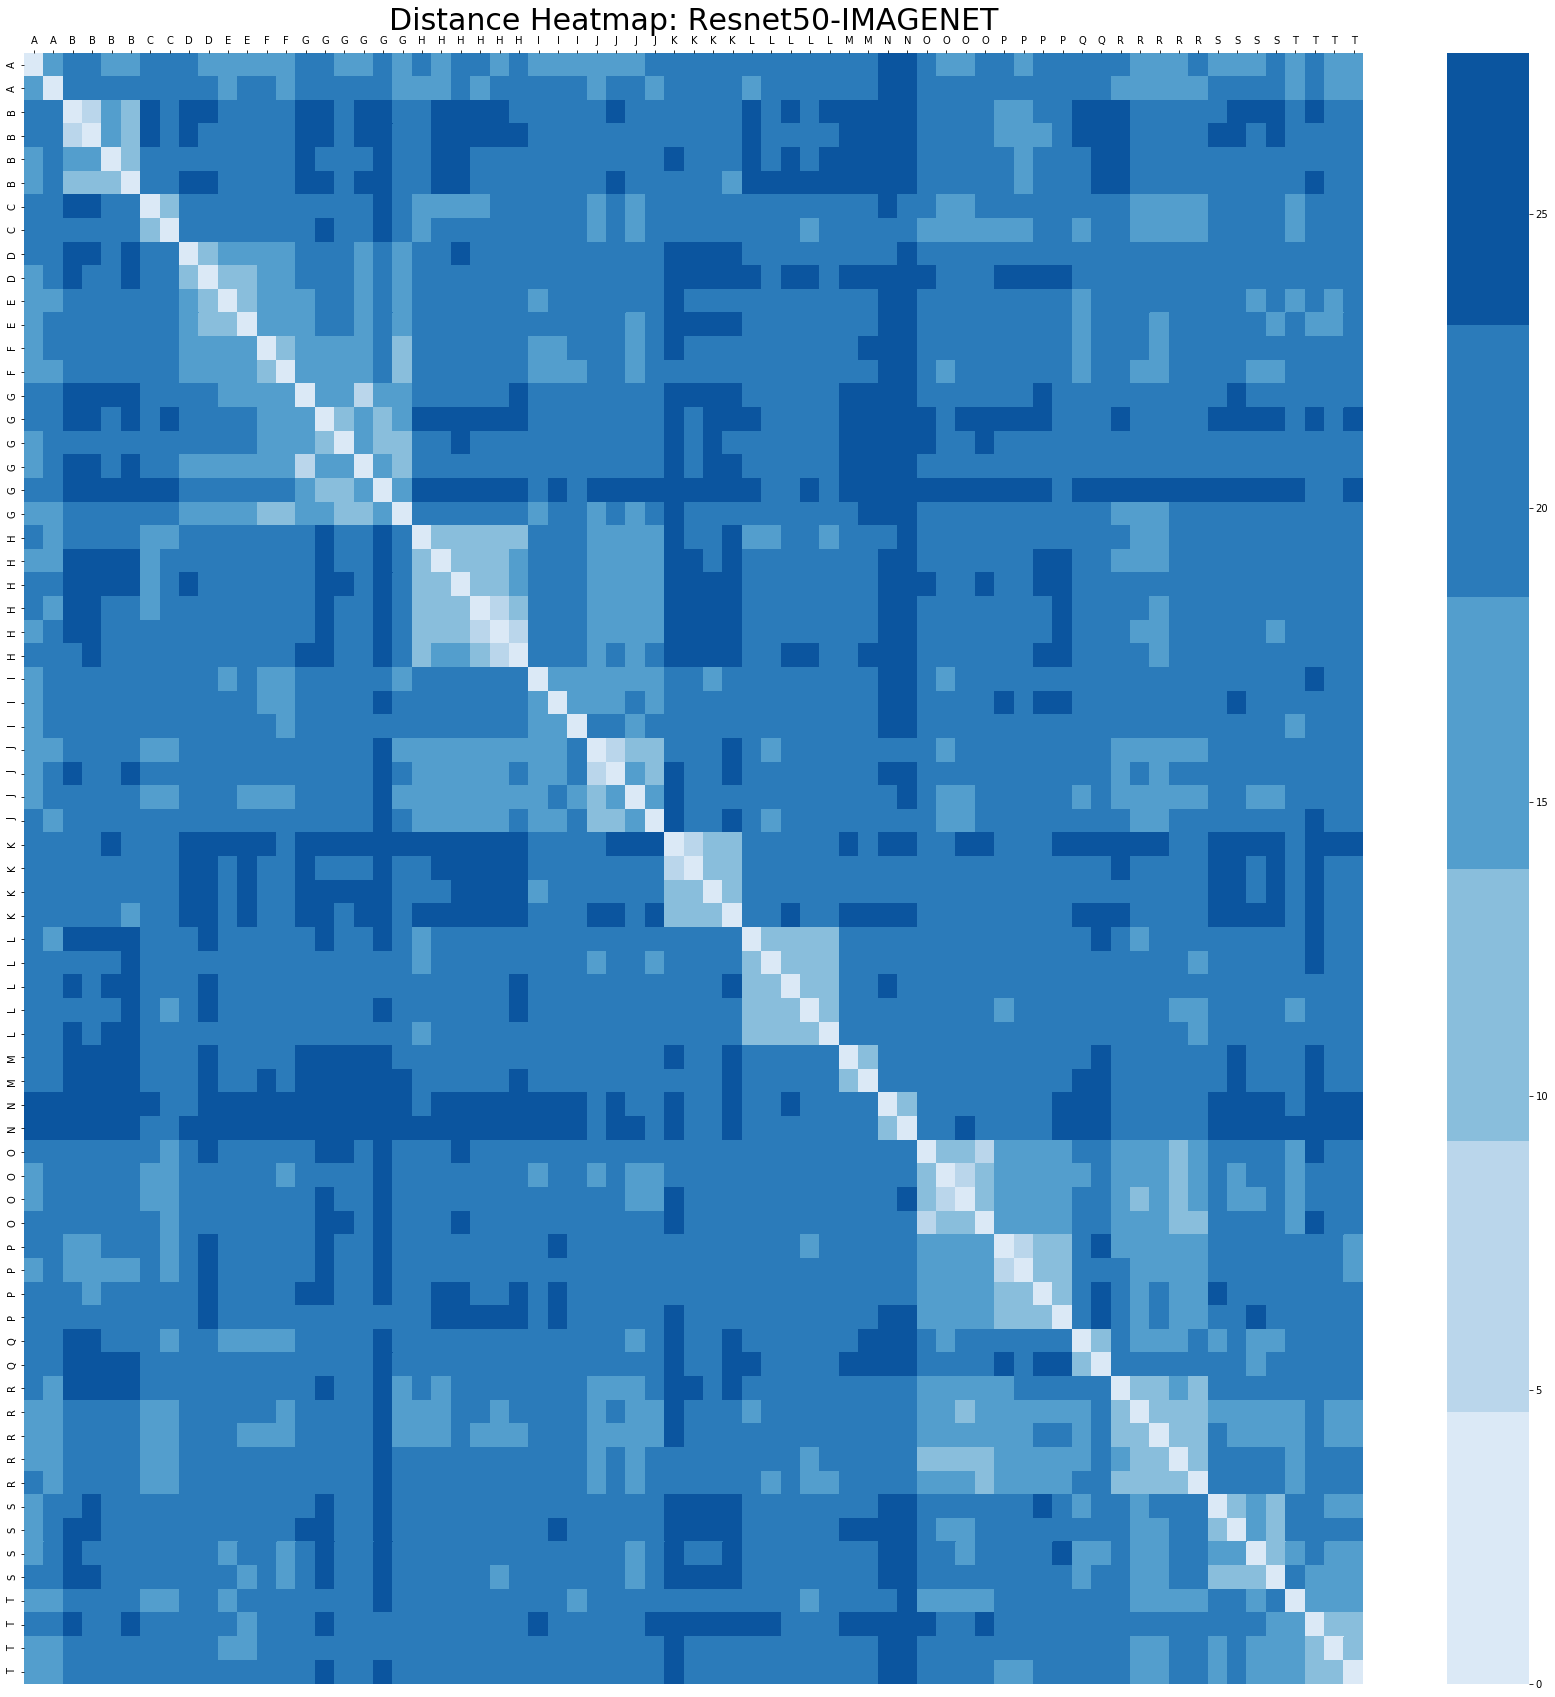

In [137]:
import matplotlib.pyplot as plt
plt.figure(figsize = (30,30))
# fig, ax = plt.subplots()
# fig.set_figheight=300
# fig.set_figwidth=300
heat_map = seaborn.heatmap(dist_mat, xticklabels=new_labels, yticklabels=new_labels, cmap=seaborn.color_palette("Blues"))
heat_map.xaxis.set_ticks_position('top')
heat_map.set_title('Distance Heatmap: Resnet50-IMAGENET', fontsize=30)
heat_map.figure.savefig('dist_mat.png')

In [139]:
resmodel = Resnet_Embedder(depth=101)

Resnet101 Embedder initialised!


In [140]:
embedding_pairs = []
for i, Xy in enumerate(dataloader):
    X, y = Xy
    embs = resmodel.forward(X)
    for i, label in enumerate(y):
        embedding_pairs.append((label, embs[i,].flatten()))

In [143]:
embedding_pairs = sorted(embedding_pairs, key=lambda x : x[0])
labels_only = [pair[0] for pair in embedding_pairs]
new_labels = [label2abc[l] for l in labels_only]
embeddings_only = [pair[1] for pair in embedding_pairs]
len(new_labels)

69

In [144]:
dist_mat = distance_matrix(embeddings_only, embeddings_only)
dist_mat.shape

(69, 69)

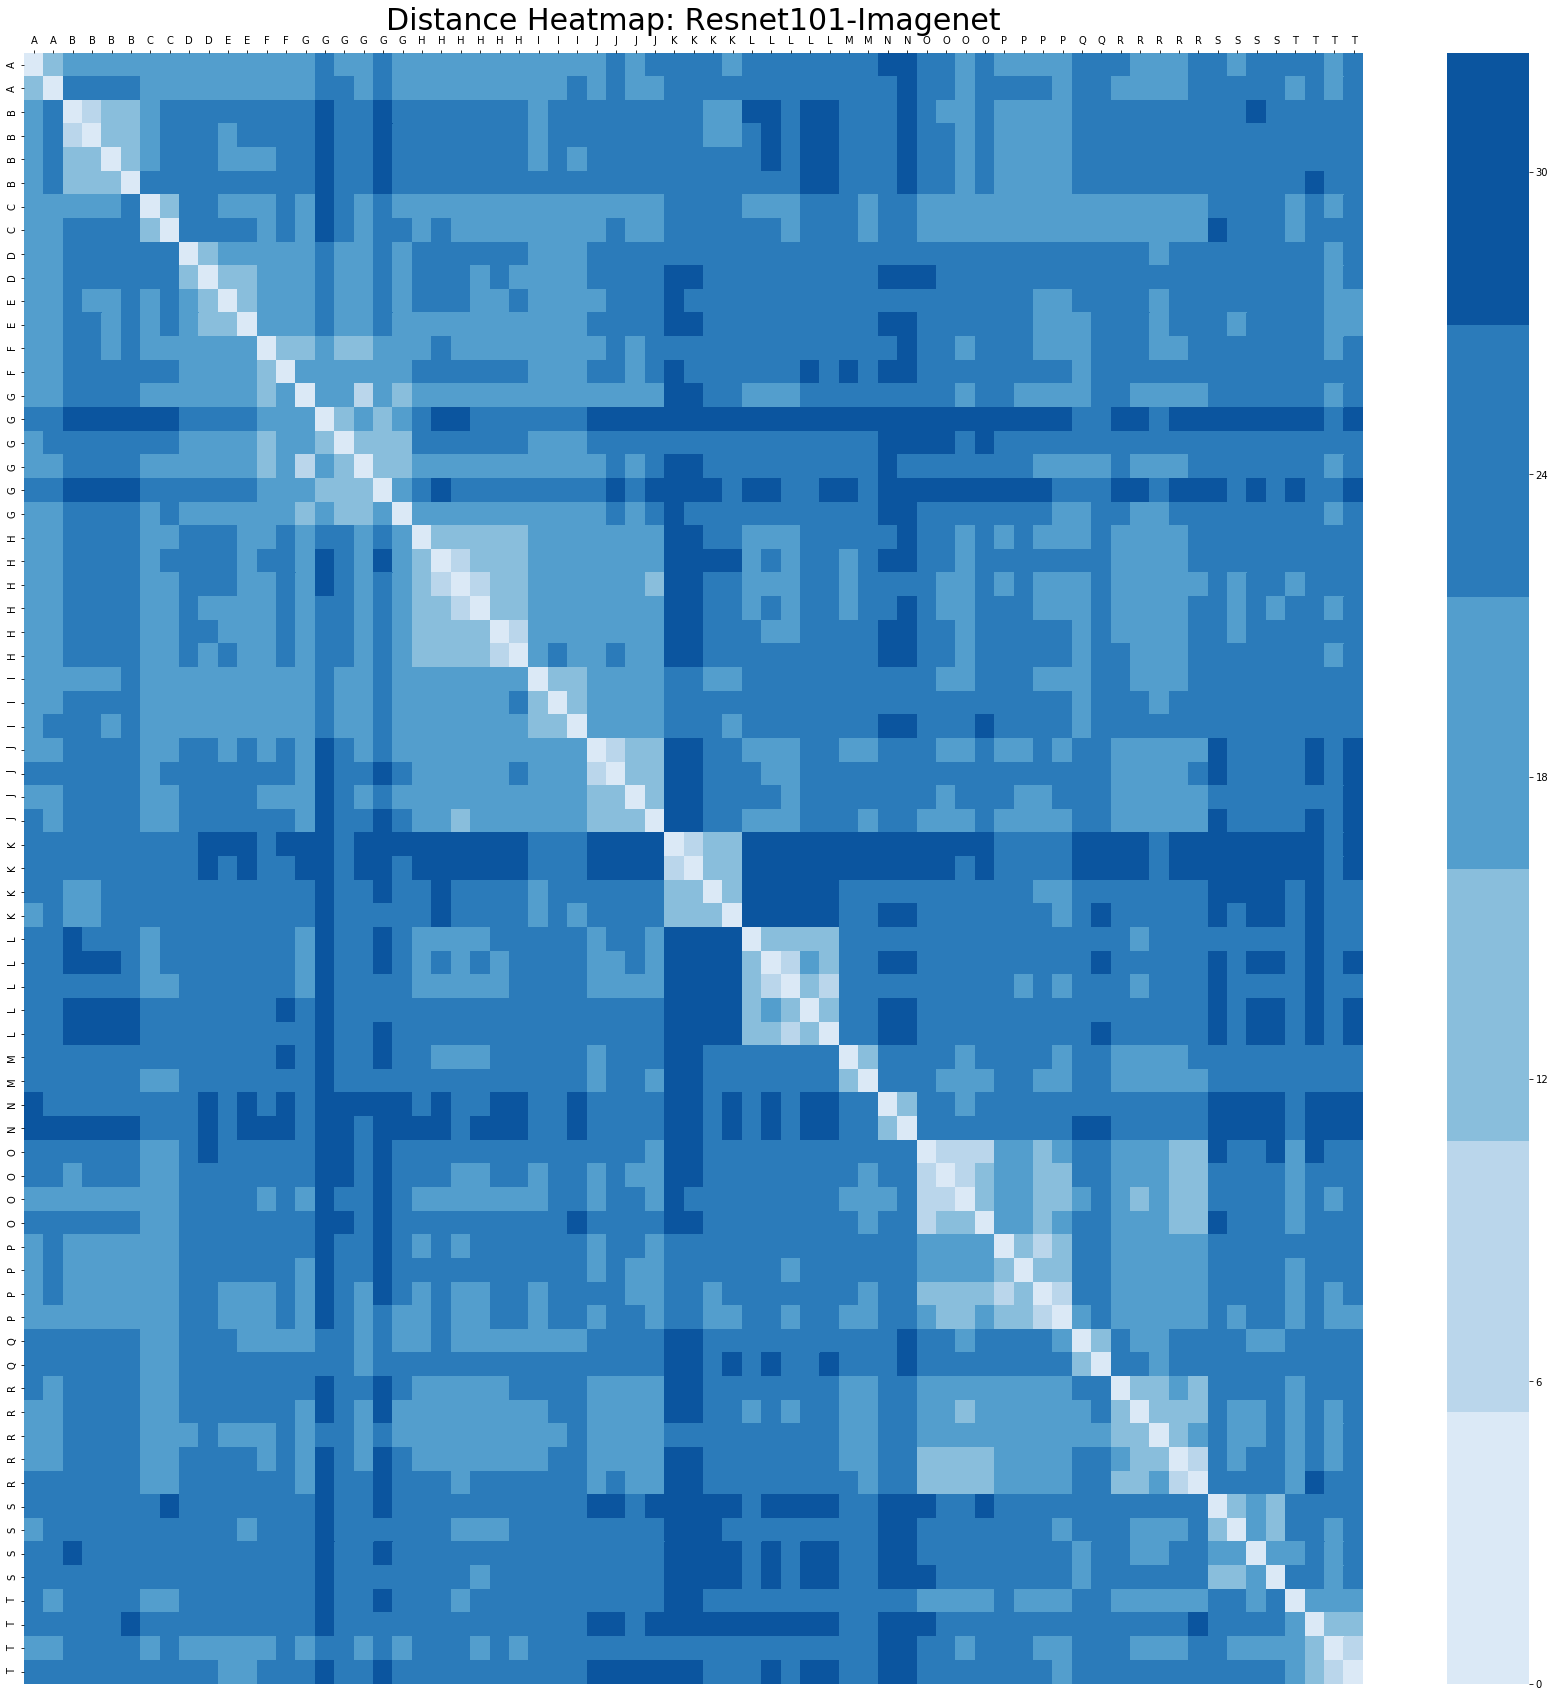

In [145]:
import matplotlib.pyplot as plt
context = 'Resnet101-Imagenet'
plt.figure(figsize = (30,30))
heat_map = seaborn.heatmap(dist_mat, xticklabels=new_labels, yticklabels=new_labels, cmap=seaborn.color_palette("Blues"))
heat_map.xaxis.set_ticks_position('top')
heat_map.set_title('Distance Heatmap: {}'.format(context), fontsize=30)
heat_map.figure.savefig('dist_mat_{}.png'.format(context))

In [146]:
resmodel = Resnet_Embedder(depth=18)

Resnet18 Embedder initialised!


In [147]:
embedding_pairs = []
for i, Xy in enumerate(dataloader):
    X, y = Xy
    embs = resmodel.forward(X)
    for i, label in enumerate(y):
        embedding_pairs.append((label, embs[i,].flatten()))

In [148]:
embedding_pairs = sorted(embedding_pairs, key=lambda x : x[0])
labels_only = [pair[0] for pair in embedding_pairs]
new_labels = [label2abc[l] for l in labels_only]
embeddings_only = [pair[1] for pair in embedding_pairs]
len(new_labels)

69

In [149]:
dist_mat = distance_matrix(embeddings_only, embeddings_only)
dist_mat.shape

(69, 69)

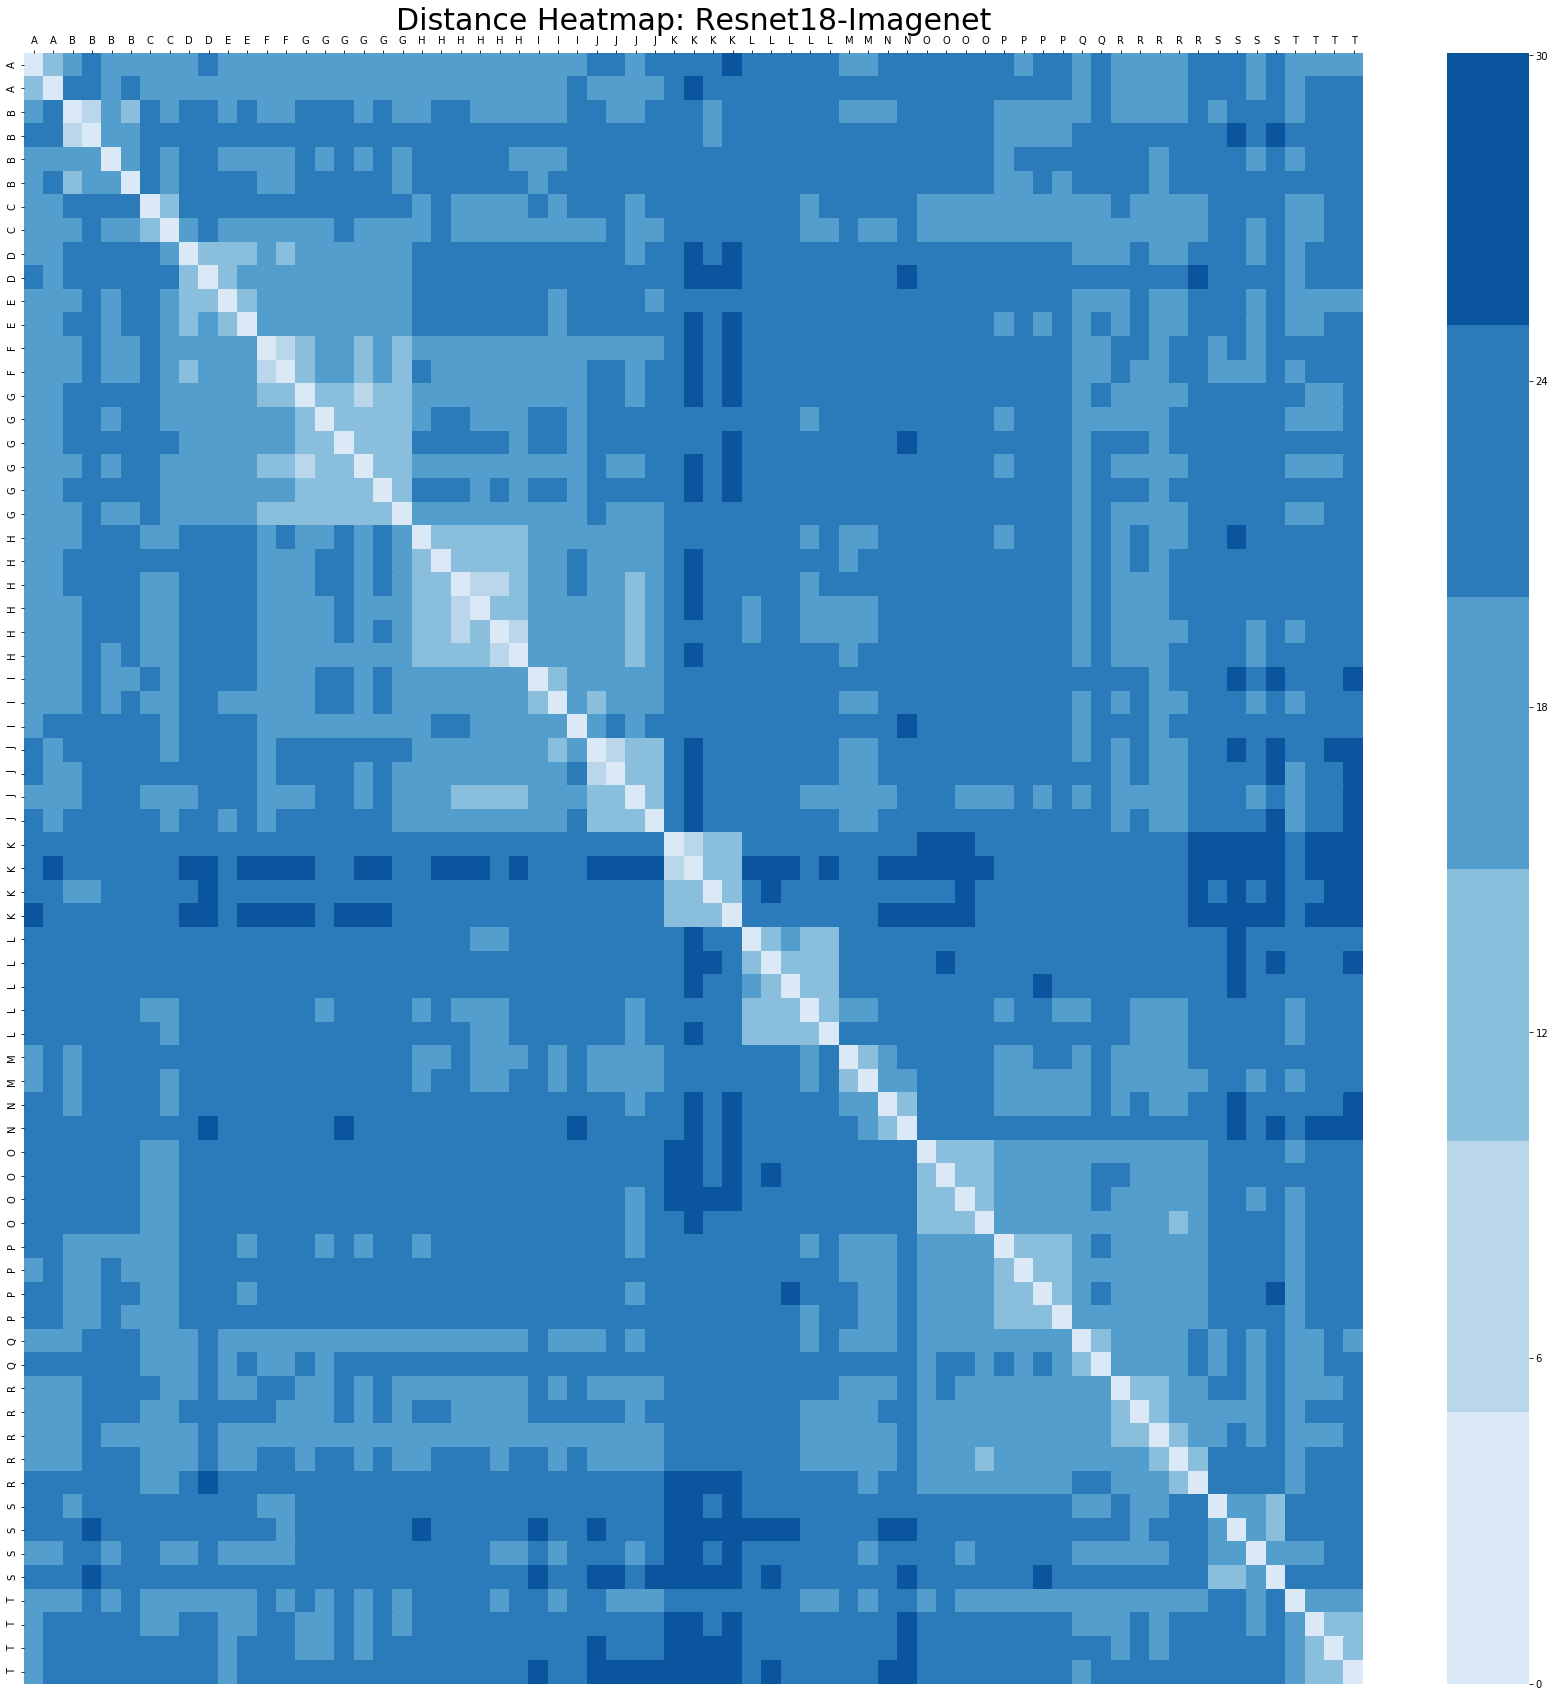

In [150]:
import matplotlib.pyplot as plt
context = 'Resnet18-Imagenet'
plt.figure(figsize = (30,30))
heat_map = seaborn.heatmap(dist_mat, xticklabels=new_labels, yticklabels=new_labels, cmap=seaborn.color_palette("Blues"))
heat_map.xaxis.set_ticks_position('top')
heat_map.set_title('Distance Heatmap: {}'.format(context), fontsize=30)
heat_map.figure.savefig('dist_mat_{}.png'.format(context))